In [ ]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler

# fetch dataset
iris = fetch_ucirepo(id=53)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
X = iris.data.features
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = iris.data.targets

In [ ]:
X.head(5)

,sepal length,sepal width,petal length,petal width
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


In [ ]:
y = y.copy()
y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

In [ ]:
# convert to a pytorch tensor
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1)
labels=labels.squeeze().long()

<font color='red'>NOTE</font>
---
No set seed in this experiment

# Break the data into batches

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Specify the model architecture and training plan

In [ ]:
# a function that creates the ANN model

def model():

    # model architecture
    ANN = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optim
    optim = torch.optim.SGD(ANN.parameters(),lr=.005)

    return ANN,lossfunc,optim

In [ ]:
# explore the model in more detail
tmpmodel = model()[0]

# print the model architecture
print(tmpmodel)

# print the model's parameters
for i in tmpmodel.named_parameters():
    print(i[0],i[1].shape,i[1].numel()) #name of parameter, size of the parameter, total number of parameters

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


# Question
---
From the above printed parameters, why is layer (1) and (3) missing?

# Function that trains the model

In [ ]:
# train the model

# global parameter
epochs = 1000

def train(alpha):
    # initialize accuracies as empties
    train_accuracy = []
    test_accuracy  = []
    losses   = []

    # count the total number of weights in the model
    new_weight = 0
    for pname,weight in ANN.named_parameters():
        if 'bias' not in pname: #we should not include the bias term in the L1 regularization (see formula in ppt)
            new_weight = new_weight + weight.numel()

    # loop over epochs
    for i in range(epochs):
        # loop over training data batches
        batch_accuracy  = []
        batch_loss = []
        for X,y in train_loader:
            # forward pass and loss
            pred = ANN(X)
            loss = lossfunc(pred,y)
            ### add L1 term
            L1_term = torch.tensor(0.,requires_grad=True) #initialize all L1 terms first to zero
            # sum up all abs(weights)
            for pname,weight in ANN.named_parameters(): #loop at all trainable parameters ()weigths
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))

            # add to loss term
            loss = loss + alpha*L1_term/(2*new_weight)
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()

            # compute training accuracy just for this batch
            batch_accuracy.append( 100*torch.mean((torch.argmax(pred,axis=1) == y).float()).item() )
            batch_loss.append( loss.item() )
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        train_accuracy.append( np.mean(batch_accuracy) )
        losses.append( np.mean(batch_loss) )

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        predlabels = torch.argmax( ANN(X),axis=1 )
        test_accuracy.append( 100*torch.mean((predlabels == y).float()).item() )

    # function output
    return train_accuracy,test_accuracy,losses


# Now for the parameteric experiment

In [ ]:
# create a 1D smoothing filter
def smooth(x,k):
    return np.convolve(x,np.ones(k)/k,mode='same')

In [ ]:
# range of L1 regularization amounts
alpha = np.linspace(0,.005,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((epochs,len(L1lambda)))
accuracyResultsTest  = np.zeros((epochs,len(L1lambda)))


# loop over batch sizes
for li in range(len(L1lambda)):
    # create and train a model
    ANN,lossfunc,optim = model()
    train_accuracy,test_accuracy,losses = train(L1lambda[li])
    # store data
    accuracyResultsTrain[:,li] = smooth(train_accuracy,10)
    accuracyResultsTest[:,li]  = smooth(test_accuracy,10)

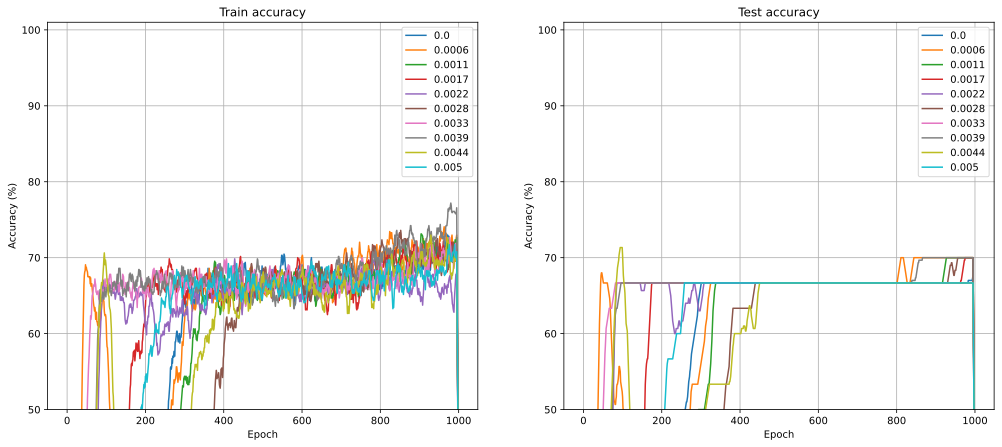

In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()
plt.show()

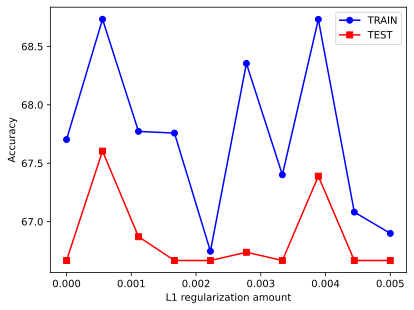

In [ ]:
# show average accuracy by L1 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Experiment

1. Redo the experiment but this time set the seed in all codes  that requires set seeding to 69.
2. Redo the experiment without the minmax scaler.

#Experiment 1

/tmp/ipython-input-1865935288.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["class"] = y["class"].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})


Training with L1 regularization = 0.00000
Training with L1 regularization = 0.00056
Training with L1 regularization = 0.00111
Training with L1 regularization = 0.00167
Training with L1 regularization = 0.00222
Training with L1 regularization = 0.00278
Training with L1 regularization = 0.00333
Training with L1 regularization = 0.00389
Training with L1 regularization = 0.00444
Training with L1 regularization = 0.00500


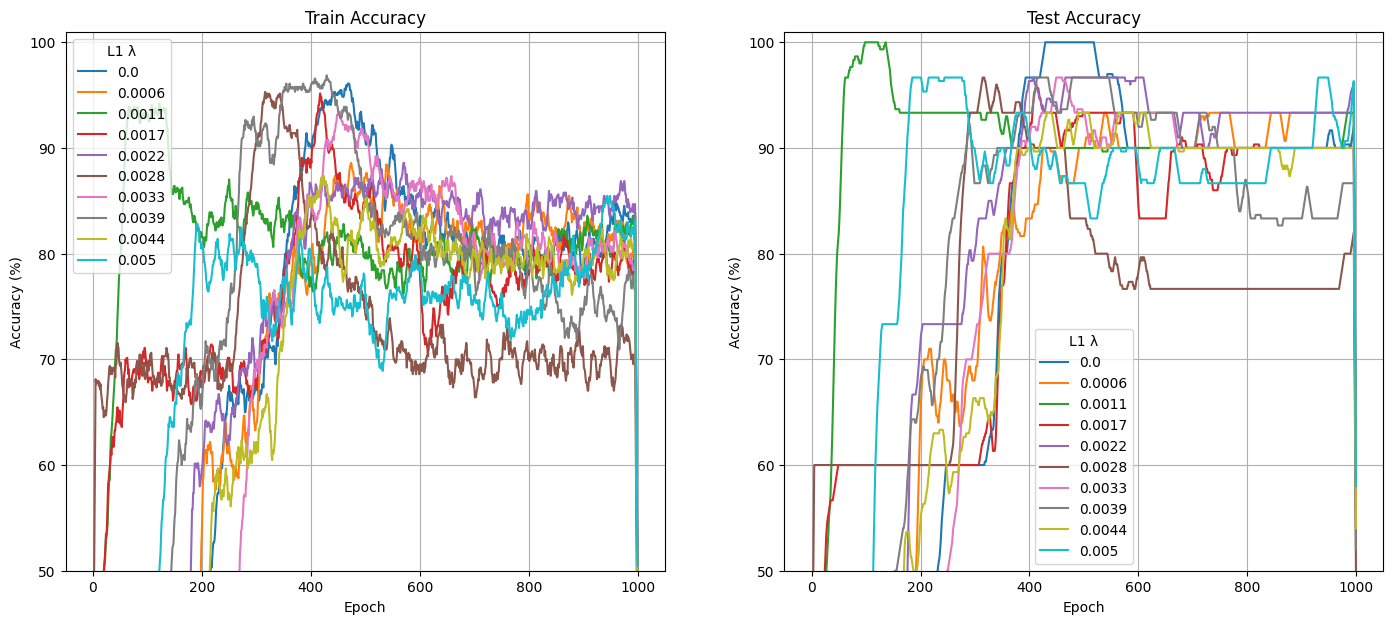

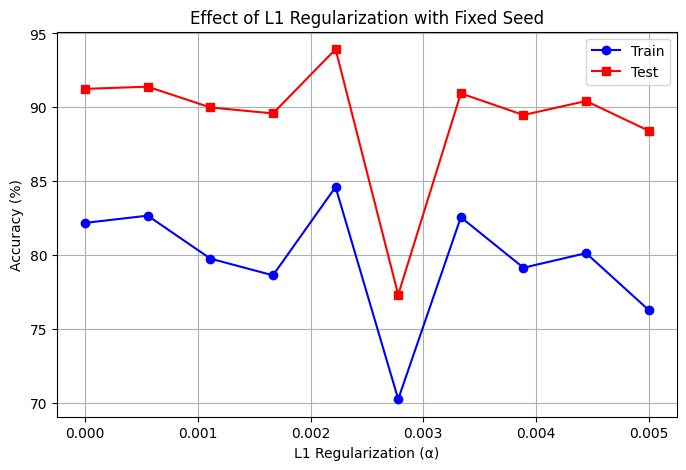

In [2]:
# =============================================================
# 🔹 Import Libraries
# =============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from ucimlrepo import fetch_ucirepo

# =============================================================
# 🔹 Set Random Seed for Reproducibility
# =============================================================
torch.manual_seed(69)
np.random.seed(69)

# =============================================================
# 🔹 Load and Preprocess the Data
# =============================================================
iris = fetch_ucirepo(id=53)

# Scale features
scaler = MinMaxScaler()
X = iris.data.features
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Encode target classes numerically
y = iris.data.targets.copy()
y["class"] = y["class"].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

# Convert to tensors
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1).squeeze().long()

# =============================================================
# 🔹 Split Data into Train and Test Sets
# =============================================================
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=69
)

# Create PyTorch datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

# =============================================================
# 🔹 Define the ANN Model
# =============================================================
def model():
    ANN = nn.Sequential(
        nn.Linear(4, 64),  # Input layer
        nn.ReLU(),
        nn.Linear(64, 64),  # Hidden layer
        nn.ReLU(),
        nn.Linear(64, 3)    # Output layer
    )

    lossfunc = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(ANN.parameters(), lr=0.005)

    return ANN, lossfunc, optim

# =============================================================
# 🔹 Train the Model with L1 Regularization
# =============================================================
epochs = 1000

def train(ANN, lossfunc, optim, alpha):
    train_accuracy, test_accuracy, losses = [], [], []

    # Count the total number of weights (excluding bias)
    total_weights = sum(w.numel() for n, w in ANN.named_parameters() if 'bias' not in n)

    for i in range(epochs):
        ANN.train()
        batch_acc, batch_loss = [], []

        for X, y in train_loader:
            pred = ANN(X)
            loss = lossfunc(pred, y)

            # L1 Regularization Term
            L1_term = torch.tensor(0., requires_grad=True)
            for n, w in ANN.named_parameters():
                if 'bias' not in n:
                    L1_term = L1_term + torch.sum(torch.abs(w))
            loss = loss + alpha * L1_term / (2 * total_weights)

            # Backpropagation
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Accuracy for this batch
            batch_acc.append(100 * torch.mean((torch.argmax(pred, axis=1) == y).float()).item())
            batch_loss.append(loss.item())

        # Average metrics for the epoch
        train_accuracy.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))

        # Evaluate on test set
        ANN.eval()
        X, y = next(iter(test_loader))
        pred = ANN(X)
        test_accuracy.append(100 * torch.mean((torch.argmax(pred, axis=1) == y).float()).item())

    return train_accuracy, test_accuracy, losses

# =============================================================
# 🔹 Run the Parametric Experiment (Different L1 Strengths)
# =============================================================
def smooth(x, k=10):
    return np.convolve(x, np.ones(k) / k, mode='same')

alpha_vals = np.linspace(0, 0.005, 10)
accuracyResultsTrain = np.zeros((epochs, len(alpha_vals)))
accuracyResultsTest = np.zeros((epochs, len(alpha_vals)))

for i, alpha in enumerate(alpha_vals):
    print(f"Training with L1 regularization = {alpha:.5f}")
    ANN, lossfunc, optim = model()
    train_acc, test_acc, losses = train(ANN, lossfunc, optim, alpha)

    accuracyResultsTrain[:, i] = smooth(train_acc, 10)
    accuracyResultsTest[:, i] = smooth(test_acc, 10)

# =============================================================
# 🔹 Plot the Results
# =============================================================
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train Accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test Accuracy')

# Common formatting
leg_labels = [np.round(a, 4) for a in alpha_vals]
for i in range(2):
    ax[i].legend(leg_labels, title="L1 λ")
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50, 101])
    ax[i].grid(True)

plt.show()

# =============================================================
# 🔹 Plot Average Accuracy by L1 Rate
# =============================================================
epoch_range = [500, 950]

plt.figure(figsize=(8, 5))
plt.plot(alpha_vals,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1], :], axis=0),
         'bo-', label='Train')
plt.plot(alpha_vals,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1], :], axis=0),
         'rs-', label='Test')
plt.xlabel('L1 Regularization (α)')
plt.ylabel('Accuracy (%)')
plt.title('Effect of L1 Regularization with Fixed Seed')
plt.legend()
plt.grid(True)
plt.show()


#Experiment 2

/tmp/ipython-input-3226775714.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["class"] = y["class"].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})


Training with L1 regularization = 0.00000
Training with L1 regularization = 0.00056
Training with L1 regularization = 0.00111
Training with L1 regularization = 0.00167
Training with L1 regularization = 0.00222
Training with L1 regularization = 0.00278
Training with L1 regularization = 0.00333
Training with L1 regularization = 0.00389
Training with L1 regularization = 0.00444
Training with L1 regularization = 0.00500


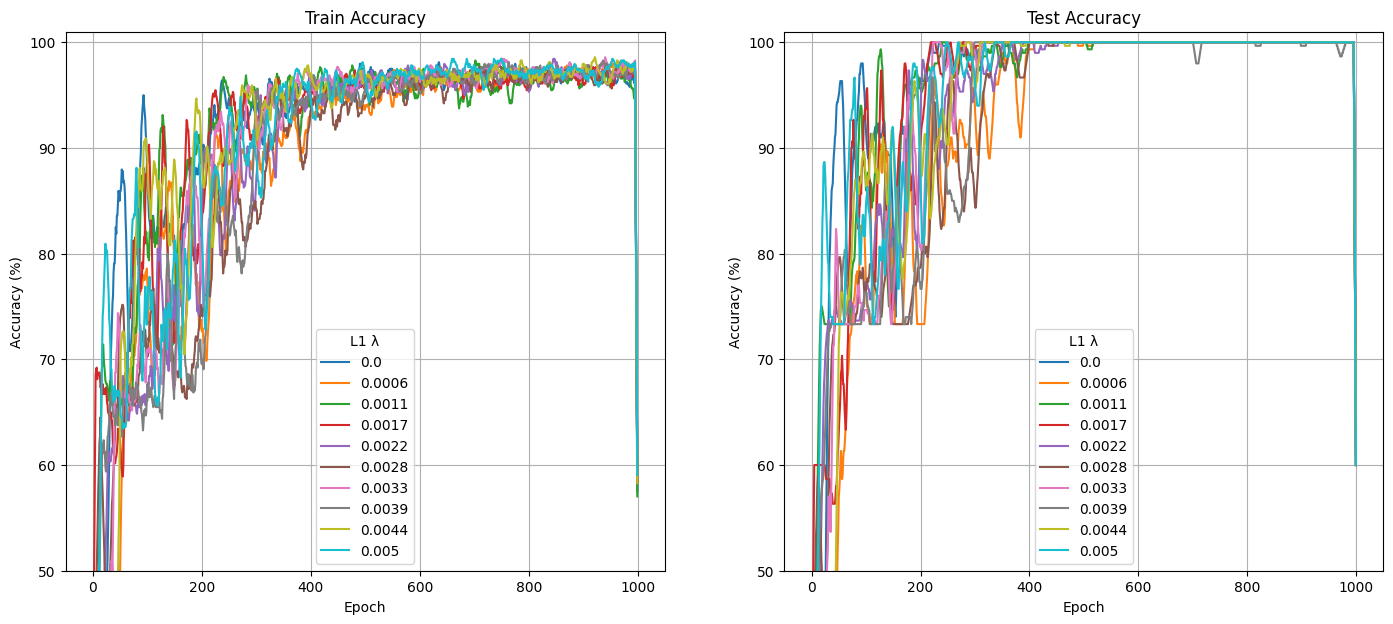

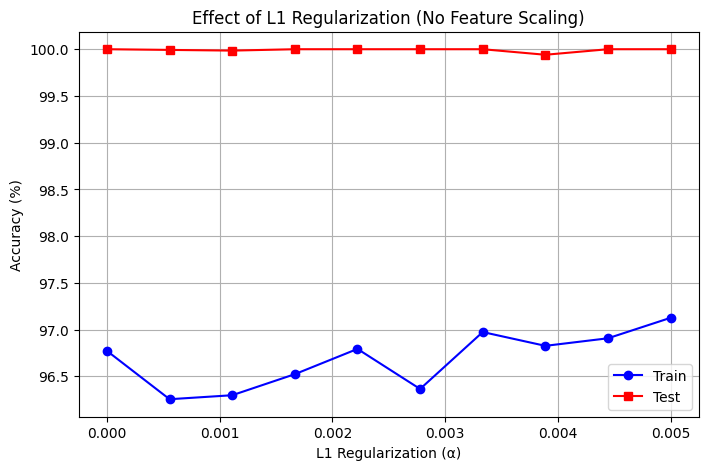

In [3]:
# =============================================================
# 🔹 Import Libraries
# =============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from ucimlrepo import fetch_ucirepo

# =============================================================
# 🔹 Set Random Seed for Reproducibility
# =============================================================
torch.manual_seed(69)
np.random.seed(69)

# =============================================================
# 🔹 Load the Iris Dataset (WITHOUT MinMaxScaler)
# =============================================================
iris = fetch_ucirepo(id=53)

X = iris.data.features  # Use raw feature values (no scaling)
y = iris.data.targets.copy()

# Encode target classes numerically
y["class"] = y["class"].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

# Convert to tensors
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1).squeeze().long()

# =============================================================
# 🔹 Split Data into Train and Test Sets
# =============================================================
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=69
)

# Create PyTorch Datasets and Loaders
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

# =============================================================
# 🔹 Define the ANN Model
# =============================================================
def model():
    ANN = nn.Sequential(
        nn.Linear(4, 64),  # Input layer
        nn.ReLU(),
        nn.Linear(64, 64),  # Hidden layer
        nn.ReLU(),
        nn.Linear(64, 3)    # Output layer
    )

    lossfunc = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(ANN.parameters(), lr=0.005)

    return ANN, lossfunc, optim

# =============================================================
# 🔹 Train the Model with L1 Regularization
# =============================================================
epochs = 1000

def train(ANN, lossfunc, optim, alpha):
    train_accuracy, test_accuracy, losses = [], [], []

    # Count number of weights (exclude bias)
    total_weights = sum(w.numel() for n, w in ANN.named_parameters() if 'bias' not in n)

    for i in range(epochs):
        ANN.train()
        batch_acc, batch_loss = [], []

        for X, y in train_loader:
            pred = ANN(X)
            loss = lossfunc(pred, y)

            # L1 Regularization
            L1_term = torch.tensor(0., requires_grad=True)
            for n, w in ANN.named_parameters():
                if 'bias' not in n:
                    L1_term = L1_term + torch.sum(torch.abs(w))
            loss = loss + alpha * L1_term / (2 * total_weights)

            # Backpropagation
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Accuracy for batch
            batch_acc.append(100 * torch.mean((torch.argmax(pred, axis=1) == y).float()).item())
            batch_loss.append(loss.item())

        train_accuracy.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))

        # Evaluate on test set
        ANN.eval()
        X, y = next(iter(test_loader))
        pred = ANN(X)
        test_accuracy.append(100 * torch.mean((torch.argmax(pred, axis=1) == y).float()).item())

    return train_accuracy, test_accuracy, losses

# =============================================================
# 🔹 Run the Parametric L1 Regularization Experiment
# =============================================================
def smooth(x, k=10):
    return np.convolve(x, np.ones(k) / k, mode='same')

alpha_vals = np.linspace(0, 0.005, 10)
accuracyResultsTrain = np.zeros((epochs, len(alpha_vals)))
accuracyResultsTest = np.zeros((epochs, len(alpha_vals)))

for i, alpha in enumerate(alpha_vals):
    print(f"Training with L1 regularization = {alpha:.5f}")
    ANN, lossfunc, optim = model()
    train_acc, test_acc, losses = train(ANN, lossfunc, optim, alpha)

    accuracyResultsTrain[:, i] = smooth(train_acc, 10)
    accuracyResultsTest[:, i] = smooth(test_acc, 10)

# =============================================================
# 🔹 Plot Results
# =============================================================
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train Accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test Accuracy')

leg_labels = [np.round(a, 4) for a in alpha_vals]
for i in range(2):
    ax[i].legend(leg_labels, title="L1 λ")
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50, 101])
    ax[i].grid(True)

plt.show()

# =============================================================
# 🔹 Plot Average Accuracy vs L1 Regularization
# =============================================================
epoch_range = [500, 950]

plt.figure(figsize=(8, 5))
plt.plot(alpha_vals,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1], :], axis=0),
         'bo-', label='Train')
plt.plot(alpha_vals,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1], :], axis=0),
         'rs-', label='Test')
plt.xlabel('L1 Regularization (α)')
plt.ylabel('Accuracy (%)')
plt.title('Effect of L1 Regularization (No Feature Scaling)')
plt.legend()
plt.grid(True)
plt.show()
